# UMBRAL DE CORTE Y EXPLOTACION DE NEGOCIO

## Objetivo de este módulo

Aprender a diseñar sistemas de machine learning personalizados a los objetivos concretos del negocio.

Mediante la explotación avanzada de conceptos como precision, recall y la ubicación del umbral de corte.

Estar en el top de data scientist que son capaces de integrar los modelos de ML con el negocio para generar resultados.

## Opciones y paquetes

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from janitor import clean_names
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler

#Automcompletar rápido
%config IPCompleter.greedy=True

## Importación de datos

Seguimos usando el mismo dataset de contratacion de fondos, y además arrastramos los avances que ya habíamos realizado sobre él.

In [ ]:
#Cargamos el dataset contratacion_fondos.csv que está en 00_DATASETS
df = pd.read_csv('../00_DATASETS/contratacion_fondos.csv',index_col=0)
df

,Edad,Trabajo,Estado Civil,Fomación,Impago,Prestamo hipotecario,Prestamo Personal,Canal de contacto,Mes,Dia de la semana,num contactos esta campaña,num días último contacto,num contactos otras campañas,resultado campaña anterior,variación tasa empleo,euribor3m,contrata_fondos
0,44.0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,NaN,1,999,0,nonexistent,14,4963,0
1,53.0,technician,married,unknown,no,no,no,cellular,nov,NaN,1,999,0,nonexistent,-1,4021,0
2,28.0,management,single,university.degree,no,yes,no,cellular,jun,NaN,3,6,2,success,-17,729,1
3,39.0,services,married,high.school,no,no,no,cellular,apr,NaN,2,999,0,nonexistent,-18,1405,0
4,55.0,retired,married,NaN,no,yes,no,cellular,aug,NaN,1,3,1,success,-29,869,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59.0,retired,married,high.school,unknown,no,yes,telephone,jun,NaN,1,999,0,nonexistent,14,4866,0
41184,31.0,housemaid,married,basic.4y,unknown,no,no,telephone,may,NaN,2,999,0,nonexistent,11,486,0
41185,42.0,admin.,single,university.degree,unknown,yes,yes,telephone,may,NaN,3,999,0,nonexistent,11,4857,0
41186,48.0,technician,married,professional.course,no,no,yes,telephone,oct,NaN,2,999,0,nonexistent,-34,742,0


In [ ]:
#Actualizamos con los avances realizados anteriormente
#LIMPIEZA DE DATOS
df = (df.
    #Limpiar nombres
    clean_names().
    #Renombrar
    rename(columns = {'fomacion':'formacion',
                      'prestamo_hipotecario':'hipoteca',
                      'prestamo_personal':'consumo'}).
    #Cambiar tipos
    astype({'edad':'Int64',
               'euribor3m': 'float'}).

    #Eliminar duplicados
    drop_duplicates().

    #Eliminar registros con más de 2 variables nulas
    dropna(thresh=16).

    #Resetear el índice
    reset_index(drop = True)
)

#IMPUTACION DE NULOS
#Eliminar dia de la semana por tener muchos nulos
df.drop(columns='dia_de_la_semana',inplace = True)

#Imputar formación para los valores nulos
imputer_formacion = SimpleImputer(strategy='constant', fill_value='NULO')
imputer_formacion.fit(df[['formacion']])
df[['formacion']] = imputer_formacion.transform(df[['formacion']])

#Imputar formación para los valores 'unknown'
imputer_formacion = SimpleImputer(missing_values = 'unknown', strategy='constant', fill_value='NULO')
imputer_formacion.fit(df[['formacion']])
df[['formacion']] = imputer_formacion.transform(df[['formacion']])

#Imputar la edad por la mediana
imputer_edad = SimpleImputer(strategy='median')
imputer_edad.fit(df[['edad']])
df[['edad']] = imputer_edad.transform(df[['edad']])

#GESTION DE ATIPICOS
#No vamos a quitar atípicos ya que realmente hemos visto que no son gran problema en este dataset

#ENCODING DE CATEGÓRICAS
#Seleccionamos las categóricas
cat = df.select_dtypes('O').copy()
#Trabajamos las nominales
nominales = ['trabajo','estado_civil','impago','hipoteca','consumo','canal_de_contacto','mes','resultado_campana_anterior']
#Instanciamos
ohe = OneHotEncoder(drop = 'first', sparse = False)
#Entrenamos
ohe.fit(cat[nominales])
#Aplicamos
cat_ohe = ohe.transform(cat[nominales])
#Ponemos los nombres
cat_ohe = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names_out(input_features = nominales))
#Trabajamos las ordinales
categorias_formacion = ['NULO','illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course','university.degree']
#Instanciamos
oe = OrdinalEncoder(categories = [categorias_formacion])
#Entrenamos
oe.fit(cat[['formacion']])
#Aplicamos
cat_oe = oe.transform(cat[['formacion']])
#Ponemos nombres
cat_oe = pd.DataFrame(cat_oe, columns = ['formacion'])

#TRANSFORMACIONES DE NUMÉRICAS
#En este caso no vamos a aplicar ninguna transformación
num = df.select_dtypes('number').copy()

#REESCALADO

#Instanciamos un minmax scaler
mms = MinMaxScaler()

#Reescalamos cat_oe
#Entrenamos
mms.fit(cat_oe)
#Aplicamos
cat_oe_r = mms.transform(cat_oe)
#Renombramos
cat_oe_r = pd.DataFrame(cat_oe_r, columns = cat_oe.columns)

#Reescalamos num
#Entrenamos
mms.fit(num)
#Aplicamos
num_r = mms.transform(num)
#Renombramos
num_r = pd.DataFrame(num_r, columns = num.columns)

#REUNIMOS TODO EL DATASET
df = pd.concat([cat_ohe,cat_oe_r,num_r], axis = 1)


df

,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,trabajo_services,trabajo_student,trabajo_technician,trabajo_unemployed,...,resultado_campana_anterior_nonexistent,resultado_campana_anterior_success,formacion,edad,num_contactos_esta_campana,num_dias_ultimo_contacto,num_contactos_otras_campanas,variacion_tasa_empleo,euribor3m,contrata_fondos
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.285714,0.333333,0.000000,1.000000,0.000000,1.000000,0.983743,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.000000,0.444444,0.000000,1.000000,0.000000,0.687500,0.796987,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.000000,0.135802,0.036364,0.006006,0.285714,0.354167,0.144330,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.714286,0.271605,0.018182,1.000000,0.000000,0.333333,0.278351,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.285714,0.160494,0.127273,1.000000,0.000000,1.000000,0.983347,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.714286,0.518519,0.000000,1.000000,0.000000,1.000000,0.964512,0.0
32662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.285714,0.172840,0.018182,1.000000,0.000000,0.937500,0.096154,0.0
32663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.000000,0.308642,0.036364,1.000000,0.000000,0.937500,0.962728,0.0
32664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.857143,0.382716,0.018182,1.000000,0.000000,0.000000,0.146907,0.0


## Contexto

## ¿Qué es el umbral de corte?


Pero todos los algoritmos de clasificación tienen también un método predict().

La diferencia es que el primero nos devuelve el scoring, mientras que el segundo nos devuelve la decisión.

Vamos a comprobarlo.

In [ ]:
#Separamos predictoras y target
x = df.drop(columns = ['contrata_fondos'])
y = df.contrata_fondos

#Creamos train y test
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.3)

#Instanciamos el modelo
from sklearn.linear_model import LogisticRegression

rl = LogisticRegression(
                penalty = 'l1',
                solver = 'saga',
                C = 1,
                n_jobs = -1)

#Entrenamos
rl.fit(train_x,train_y)

#Aplicamos
pred_rl = rl.predict_proba(test_x)[:,1]
pred_rl

array([0.06049854, 0.13114245, 0.05712272, ..., 0.02562123, 0.02300725,
       0.02661819])

In [ ]:
rl.predict(test_x)

array([0., 0., 0., ..., 0., 0., 0.])

El motivo por el que no me gusta predict() es porque la forma en la que toma la decisión es si el scoring es superior a 0.5.

Es decir, si scoring > 0.5 entonces 1 y si no 0.

Pero ésto sólo tiene sentido si la proporción de clases es la misma (o si hemos balanceado).

Y ya sabemos que en la empresa esto no pasa.

Por ej si la penetración media de un producto es de 0.1, pero el modelo está prediciendo "compra" a partir de 0.5, entonces lo que está haciendo implícitamente es pedir que un cliente tenga que ser 5 veces más propenso a comprar que la media para decir que será un comprador.

Por eso a mi me gusta trabajar siempre con el porcentaje del scoring y luego decidir yo donde pongo el umbral de corte.

Pero ahora viene donde nos explota la cabeza.

Resulta que todas estas métricas tan importantes como la matriz de confusión, precision, recall y F1 no son fijas.

Si no que dependen directamente del umbral de corte!!

*NOTA: el AUC no depende del punto de corte, por eso es una mejor métrica para comparar y por eso la hemos venido usando masivamente*

## El umbral de corte determina las métricas (excepto el ROC-AUC)

Lo anterior significa que si cambiamos el umbral de corte también nos cambia la matriz de confusión, precision, recall y F1.

Vamos a comprobarlo.

In [ ]:
from sklearn.metrics import confusion_matrix

def calcular_metricas(real, scoring, umbral):

    #CALCULAR LA DECISION SEGUN EL UMBRAL
    predicho = np.where(scoring > umbral,1,0)

    #CALCULAR TODAS LAS MÉTRICAS
    conf = confusion_matrix(real,predicho)

    tn, fp, fn, tp = conf.ravel()

    total_casos = y.shape[0]

    accuracy = (tn + tp) / total_casos
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)

    #IMPRIMIR RESULTADOS
    print('\nMatriz de confusión\n',pd.DataFrame(conf))
    print('\naccuracy:',round(accuracy,3))
    print('\nprecision:',round(precision,3))
    print('\nrecall:',round(recall,3))
    print('\nF1:',round(F1,3))

In [ ]:
calcular_metricas(test_y, pred_rl, 0.5)


Matriz de confusión
       0    1
0  8545  137
1   908  210

accuracy: 0.268

precision: 0.605

recall: 0.188

F1: 0.287


Fíjate en cómo la precisión sale más alta, ya que el corte de 0.5 supone aprox solo decir que serán unos los que estén 2.5 veces por encima de la penetración de la target.

In [ ]:
calcular_metricas(test_y, pred_rl, 0.2)


Matriz de confusión
       0    1
0  7790  892
1   538  580

accuracy: 0.256

precision: 0.394

recall: 0.519

F1: 0.448


Fíjate cómo al haber bajado el umbral:

1. Todos los datos cambian
2. La precisión baja
3. La cobertura sube

## Personalizar el sistema mediante el umbral de corte

Lo anterior significa que nosotros podemos modular el mismo modelo para ajustarlo mejor a cada objetivo de negocio.

Incluso podemos cambiar la salida (priorizar precision o recall) de forma dinámica sin tener que crear o actualizar el modelo!!

Ejemplo sistema de identificación de fraude de los bancos.

Para ayudarnos a elegir el mejor punto de corte para nuestros objetivos tenemos 2 herramientas:

* El gráfico de precision-recall
* El gráfico de umbrales de corte

### Gráfico de precision-recall

Con este gráfico podemos ver la relación entre precision y recall a lo largo de los umbrales de corte, y buscar si existen zonas que se adapten a nuestros objetivos.

Aprendimos a hacerlo hace ya muchas lecciones.

Y te dije que lo utilizaríamos posteriormente. Pues es ahora.


Para hacer este gráfico vamos a usar plot_precision_recall_curve del módulo metrics, al que hay que pasarle el modelo, las predictoras y la target.

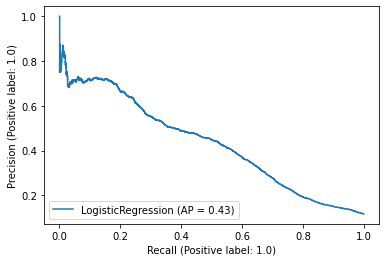

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(rl,x,y);

### Gráfico de umbrales de corte

Con este gráfico podemos ver las métricas de precision, recall y F1 para cada uno de los umbrales de corte y buscar el que maximiza nuestro objetivo.


Para hacer este gráfico vamos a usar la función discrimination_threshold del paquete yellowbrick, a la que hay que pasarle el modelo, las predictoras y la target.

C:\Users\isaac\miniconda3\envs\PDSM\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


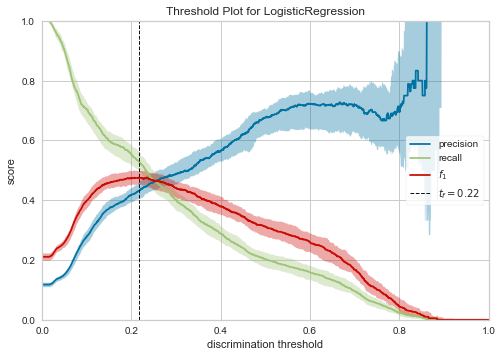

In [ ]:
from yellowbrick.classifier import discrimination_threshold

discrimination_threshold(rl,x,y, exclude = 'queue_rate');

Por ejemplo, si nuestro objetivo prioritario fuera el precision el gráfico nos dice que podemos conseguir un precision en torno a 0.7 con umbrales entre 0.55 y 0.8, pero cuanto más cercano a 0.55 más recall mantendremos sin bajar mucho el precision.

Vamos a comprobarlo.

In [ ]:
calcular_metricas(test_y, pred_rl, 0.55)


Matriz de confusión
       0    1
0  8583   99
1   921  197

accuracy: 0.269

precision: 0.666

recall: 0.176

F1: 0.279


In [ ]:
calcular_metricas(test_y, pred_rl, 0.8)


Matriz de confusión
       0   1
0  8662  20
1  1089  29

accuracy: 0.266

precision: 0.592

recall: 0.026

F1: 0.05


## Uso práctico del Umbral de Corte

Fíjate en los ejemplos anteriores que el modelo no cambia, siempre es el mismo, pero cambiando el umbral conseguimos resultados totalmente diferentes.

Ejemplos de uso:

* En un sistema de fraude en compras con tarjeta:
    * Si subimos el umbral: bloqueamos menos tarjetas pero se nos escapa más fraude
    * Si bajamos el umbral: evitamos más fraude pero se enfadan más clientes
    
* En una prueba diagnóstica:
    * Si subimos el umbral: gastamos menos presupuesto en tratamiento, pero enferman más personas
    * Si bajamos el umbral: prevenimos más enfermedades pero gastamos más dinero
    
* En un sistema de prevención de abandono:
    * Si subimos el umbral: podemos gestionar mejor y con más presupuesto los clientes que identifiquemos, pero no serán muchos
    * Si bajamos el umbral: podemos gestionar más clientes, pero en muchos de ellos estaremos tirando el dinero ya que no se iban a ir
    
* En un sistema de mantenimiento preventivo:
    * Si subimos el umbral: gastamos poco en inspecciones pero detectamos menos máquinas que se va a estropear
    * Si bajamos el umbral: se estropean menos máquinas, pero gastamos en mantenimientos de máquinas que no lo necesitaban

## Selección del umbral según el Valor Esperado

En muchos contextos de negocio no querremos tomar una decisión estratégica tan "artesanal" si no encontrar el valor que maximiza el valor esperado según unos escenarios de ingresos y costes.

A partir de una matriz de confusión podemos asignar ingresos a los aciertos y costes a los errores.

Por ejemplo:

* En una campaña comercial cada vez que acertemos tendremos el ingreso de una compra, y cada vez que fallemos tendremos el coste del contacto comercial
* En una inspección de fraude cada vez que acertemos tendremos el ingreso del fraude evitado, y cada vez que fallemos tendremos el coste de la inspección
* En un sistema de riesgo de crédito cada vez que acertemos tendremos el ingreso del capital impagado que hemos evitado, y cada vez que fallemos tendremos el coste del margen financiero que hubiéramos obtenido

Los pasos para aplicar este framework son:

1. Definir en el caso concreto la matriz de impacto esperado
2. Recorrer todos los umbrales, calcular su matriz de confusión y multiplicarla por la de impacto para calcular el valor esperado
3. Encontrar el umbral que maximiza el impacto esperado

Vamos a crear una función que automatice los puntos 1 y 2.

In [ ]:
def max_roi(real,scoring, salida = 'grafico'):

    #DEFINIMOS LA MATRIZ DE IMPACTO
    ITN = 0
    IFP = -15
    IFN = -85
    ITP = 85

    #DEFINIMOS LA FUNCION DEL VALOR ESPERADO
    def valor_esperado(matriz_conf):
        TN, FP, FN, TP = conf.ravel()
        VE = (TN * ITN) + (FP * IFP) + (FN * IFN) + (TP * ITP)
        return(VE)

    #CREAMOS UNA LISTA PARA EL VALOR ESPERADO
    ve_list = []

    #ITERAMOS CADA PUNTO DE CORTE Y RECOGEMOS SU VE
    for umbral in np.arange(0,1,0.01):
        predicho = np.where(scoring > umbral,1,0)
        conf = confusion_matrix(real,predicho)
        ve_temp = valor_esperado(conf)
        ve_list.append(tuple([umbral,ve_temp]))

    #DEVUELVE EL RESULTADO COMO TGRAFICO O COMO EL UMBRAL ÓPTIMO
    df_temp = pd.DataFrame(ve_list, columns = ['umbral', 'valor_esperado'])
    if salida == 'grafico':
        solo_ve_positivo = df_temp[df_temp.valor_esperado > 0]
        plt.figure(figsize = (12,6))
        sns.lineplot(data = solo_ve_positivo, x = 'umbral', y = 'valor_esperado')
        plt.xticks(solo_ve_positivo.umbral, fontsize = 14)
        plt.yticks(solo_ve_positivo.valor_esperado, fontsize = 12);
    else:
        return(df_temp.iloc[df_temp.valor_esperado.idxmax(),0])

Vamos a llamar a la función para nuestro ejemplo:

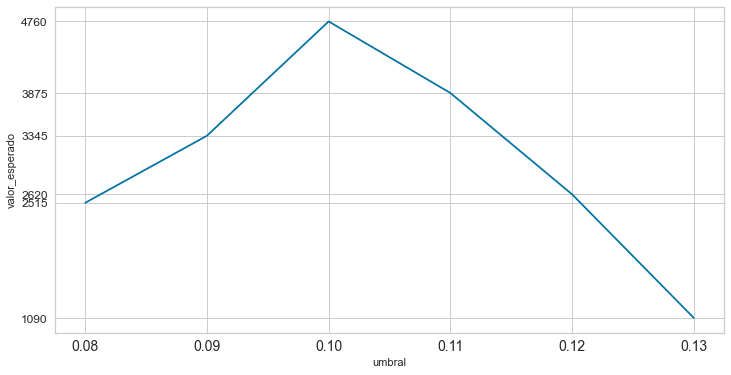

In [ ]:
max_roi(test_y, pred_rl)

Si quisiéramos una decisión automática podríamos llamar a la función especificando el modo automatico.

In [ ]:
max_roi(test_y, pred_rl, salida = 'automatico')

0.1